In [35]:
import os
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [36]:
# ============================
# 1. Setup and Configuration
# ============================

# Configure logging
logging.basicConfig(filename='dataset_info.log', level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')

# Define paths
labels_path = './Facial Database/labels.csv'  # Path to your labels CSV
source_dir = './Facial Database'             # Directory containing images

In [37]:
# ============================
# 2. Load Labels
# ============================

# Load the labels CSV into a DataFrame
try:
    labels_df = pd.read_csv(labels_path)
    print(f"Loaded labels.csv with {len(labels_df)} entries.")
except FileNotFoundError:
    logging.error(f"Labels file not found at path: {labels_path}")
    raise

# Display first few entries
print("\nFirst 5 entries in labels.csv:")
print(labels_df.head())

Loaded labels.csv with 28175 entries.

First 5 entries in labels.csv:
   Unnamed: 0                     pth     label    relFCs
0           0  anger/image0000006.jpg  surprise  0.873142
1           1  anger/image0000060.jpg     anger  0.852311
2           2  anger/image0000061.jpg     anger  0.800957
3           3  anger/image0000066.jpg   disgust  0.843079
4           4  anger/image0000106.jpg     anger  0.849108


In [38]:
# ============================
# 3. Basic Statistics
# ============================

# Total number of images
total_images = len(labels_df)
print(f"\nTotal number of images: {total_images}")

# Number of unique classes
unique_classes = labels_df['label'].unique()
num_classes = len(unique_classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {unique_classes}")

# Number of images per class
images_per_class = labels_df['label'].value_counts()
print("\nNumber of images per class:")
print(images_per_class)


Total number of images: 28175
Number of classes: 8
Classes: ['surprise' 'anger' 'disgust' 'fear' 'sad' 'contempt' 'neutral' 'happy']

Number of images per class:
label
surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64


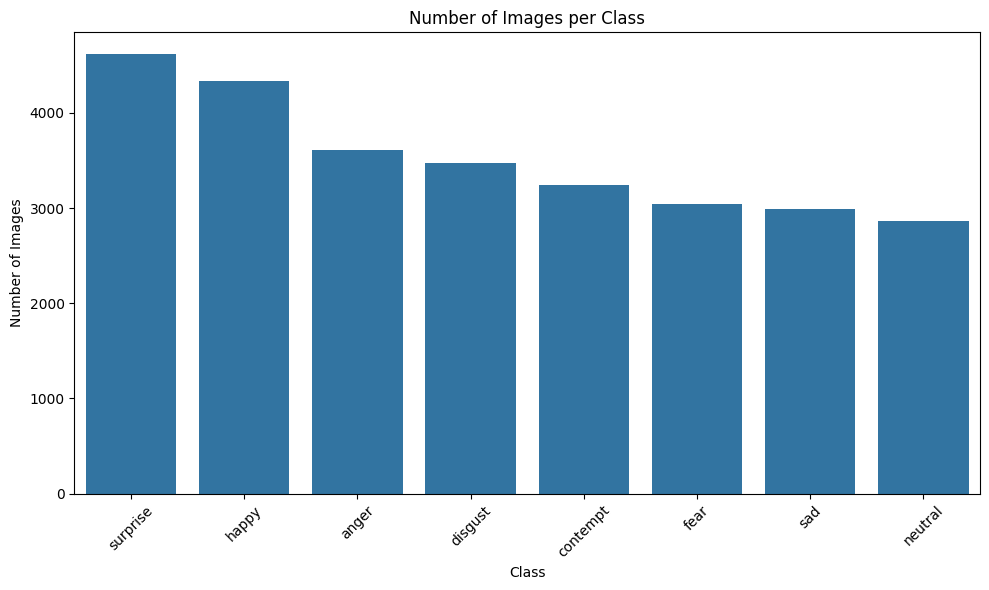

In [39]:
# ============================
# 4. Class Distribution Visualization
# ============================

plt.figure(figsize=(10, 6))
sns.barplot(x=images_per_class.index, y=images_per_class.values)
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# ============================
# 5. Image Properties Analysis
# ============================

# Initialize lists to store image properties
widths = []
heights = []
channels = []
corrupted_images = []
missing_images = []

# Iterate through the DataFrame to collect image properties
for idx, row in labels_df.iterrows():
    img_path = os.path.join(source_dir, row['pth'])
    if not os.path.exists(img_path):
        missing_images.append(img_path)
        logging.warning(f"Missing file: {img_path}")
        continue
    try:
        with Image.open(img_path) as img:
            # Ensure image is loaded
            img.verify()
        with Image.open(img_path) as img:
            img = img.convert('RGB')  # Convert to RGB to standardize
            widths.append(img.width)
            heights.append(img.height)
            channels.append(len(img.getbands()))
    except (IOError, UnidentifiedImageError) as e:
        corrupted_images.append(img_path)
        logging.warning(f"Corrupted image file: {img_path}")

# Report corrupted and missing images
print(f"\nNumber of missing images: {len(missing_images)}")
print(f"Number of corrupted images: {len(corrupted_images)}")
if len(missing_images) > 0:
    print("Missing images have been logged in 'dataset_info.log'.")
if len(corrupted_images) > 0:
    print("Corrupted images have been logged in 'dataset_info.log'.")

# Remove corrupted and missing images from analysis
valid_indices = labels_df['pth'].apply(lambda x: os.path.exists(os.path.join(source_dir, x)) and
                                                 x not in corrupted_images)
valid_labels_df = labels_df[valid_indices].reset_index(drop=True)

# Update counts
print(f"\nNumber of valid images for property analysis: {len(valid_labels_df)}")


Number of missing images: 0
Number of corrupted images: 0

Number of valid images for property analysis: 28175


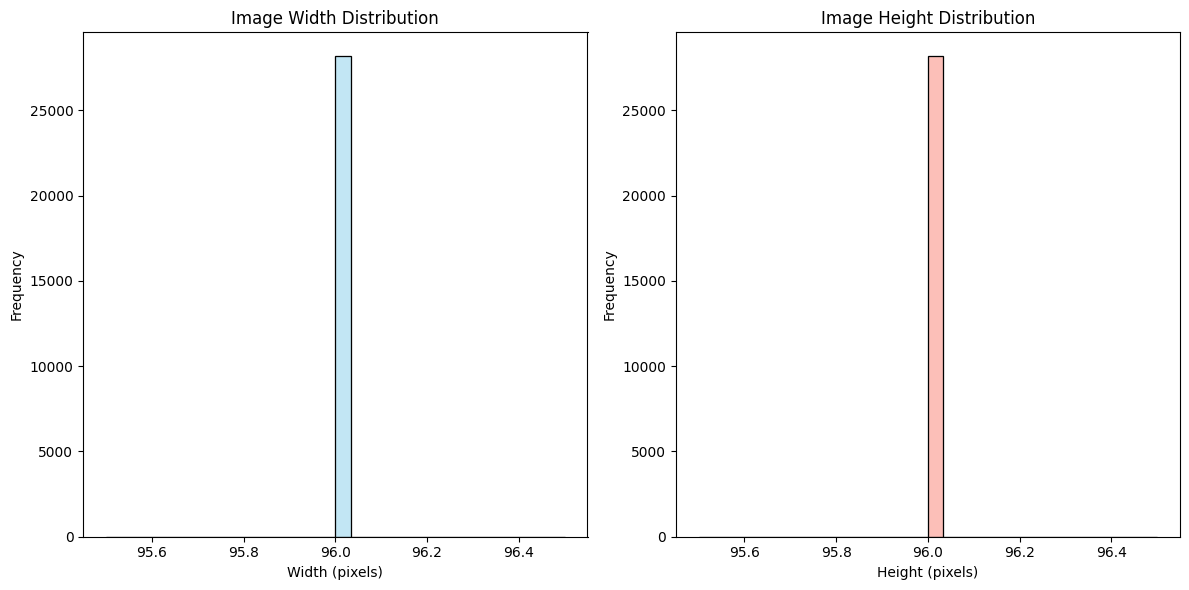

In [41]:
# ============================
# 6. Image Size Distribution
# ============================

plt.figure(figsize=(12, 6))

# Width Distribution
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30, kde=True, color='skyblue')
plt.title('Image Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Height Distribution
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30, kde=True, color='salmon')
plt.title('Image Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Image Channels Distribution:
3    28175
Name: count, dtype: int64


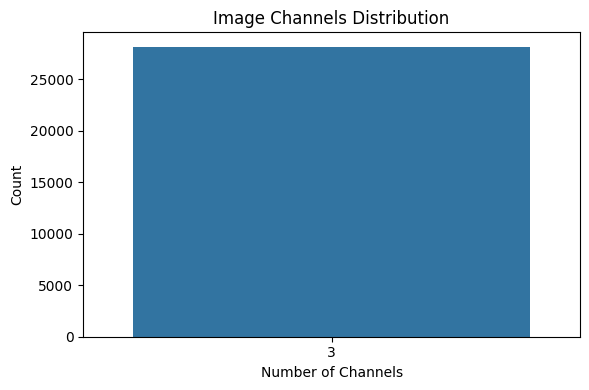

In [42]:
# ============================
# 7. Image Channels Verification
# ============================

channel_counts = pd.Series(channels).value_counts()
print("\nImage Channels Distribution:")
print(channel_counts)

# Plot the channel distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=channel_counts.index.astype(str), y=channel_counts.values)
plt.title('Image Channels Distribution')
plt.xlabel('Number of Channels')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Displaying sample images from each class:


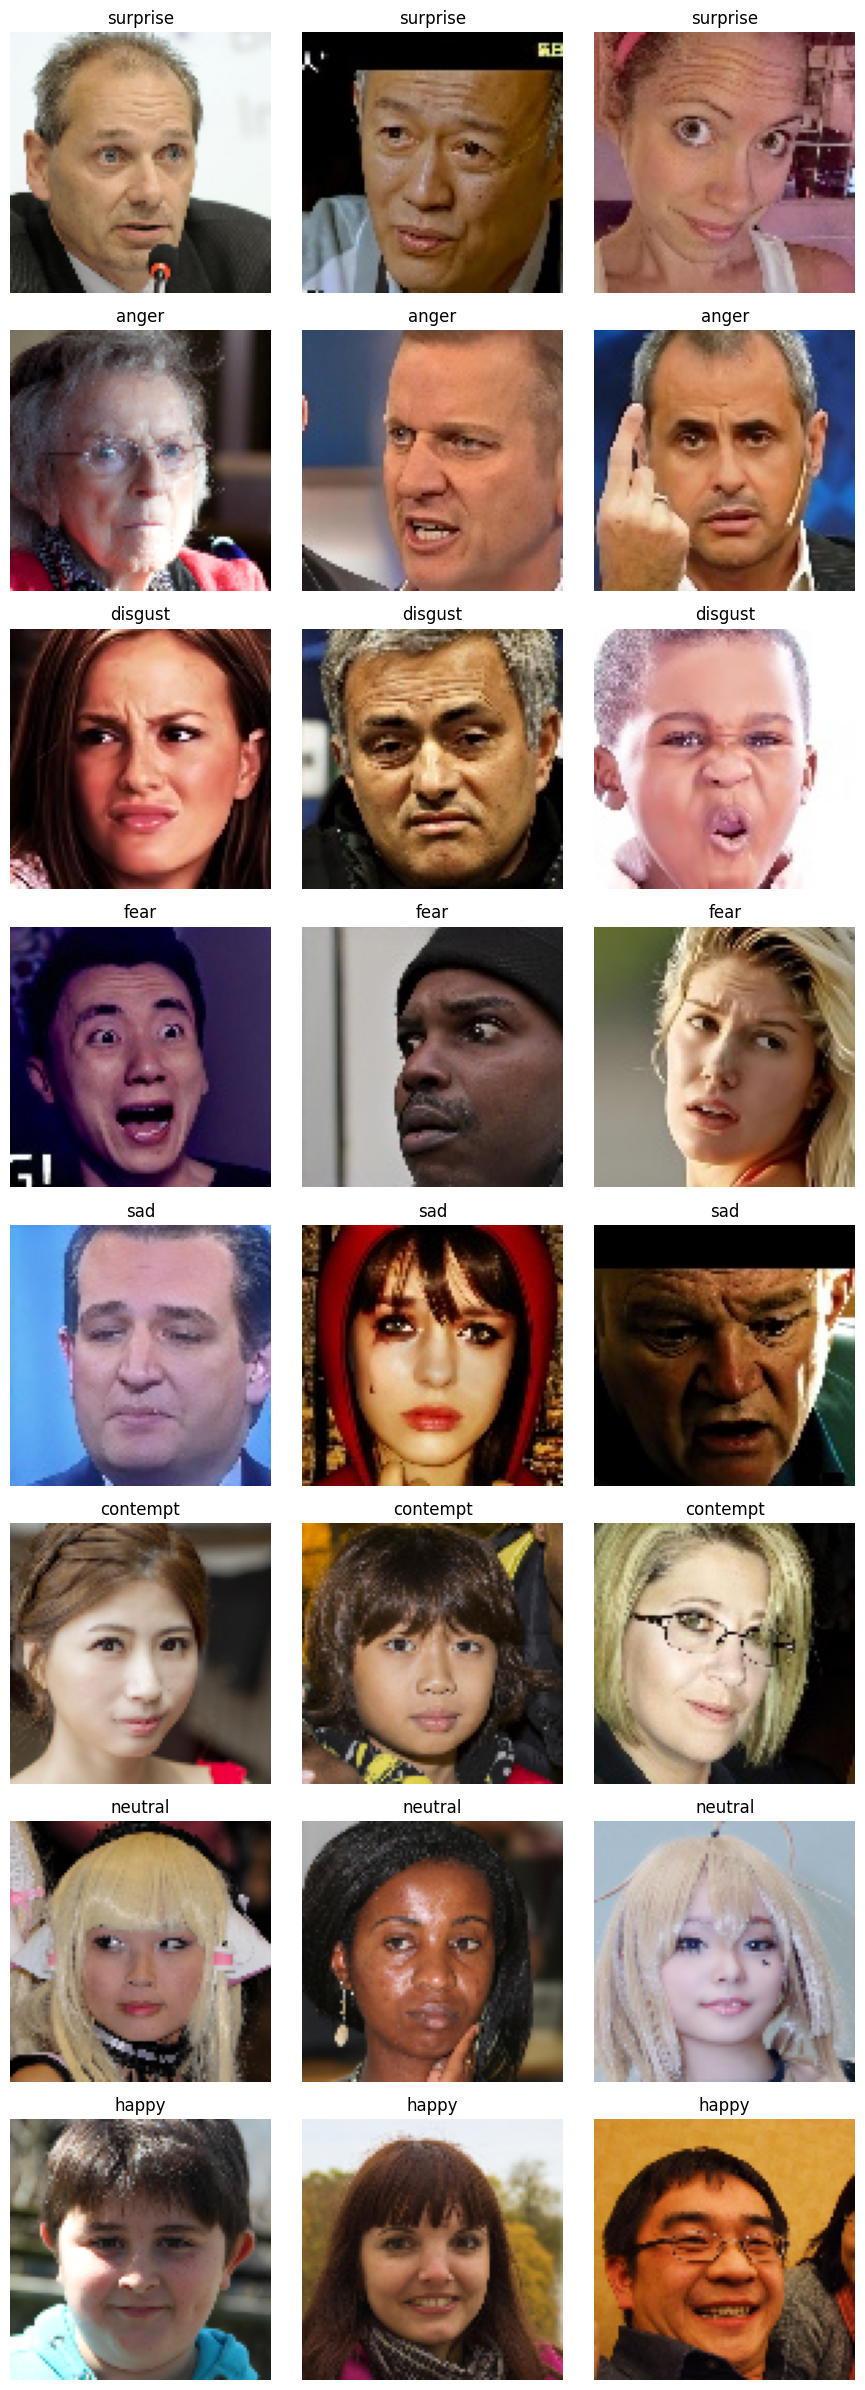

In [43]:
# ============================
# 8. Sample Images Display
# ============================

import math

def display_sample_images(df, num_classes, samples_per_class=3):
    """Display sample images from each class."""
    plt.figure(figsize=(samples_per_class * 3, num_classes * 3))
    for i, cls in enumerate(unique_classes):
        cls_df = df[df['label'] == cls].sample(n=min(samples_per_class, len(df[df['label'] == cls])), random_state=42)
        for j, (_, row) in enumerate(cls_df.iterrows()):
            img_path = os.path.join(source_dir, row['pth'])
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')
                    plt_idx = i * samples_per_class + j + 1
                    plt.subplot(num_classes, samples_per_class, plt_idx)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')
            except:
                continue
    plt.tight_layout()
    plt.show()

# Display sample images
print("\nDisplaying sample images from each class:")
display_sample_images(valid_labels_df, num_classes, samples_per_class=3)

In [44]:
# ============================
# 9. Summary Report
# ============================

print("\n==============================")
print("Dataset Summary Report:")
print("==============================")
print(f"Total images: {total_images}")
print(f"Valid images: {len(valid_labels_df)}")
print(f"Missing images: {len(missing_images)}")
print(f"Corrupted images: {len(corrupted_images)}")
print(f"Number of classes: {num_classes}")
print("Images per class:")
print(images_per_class)
print("Image size statistics:")
print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}, Median: {np.median(widths)}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}, Median: {np.median(heights)}")
print("Image channels distribution:")
print(channel_counts)
print("==============================")
print("Detailed logs are saved in 'dataset_info.log'.")


Dataset Summary Report:
Total images: 28175
Valid images: 28175
Missing images: 0
Corrupted images: 0
Number of classes: 8
Images per class:
label
surprise    4616
happy       4336
anger       3608
disgust     3472
contempt    3244
fear        3043
sad         2995
neutral     2861
Name: count, dtype: int64
Image size statistics:
Width - Min: 96, Max: 96, Mean: 96.00, Median: 96.0
Height - Min: 96, Max: 96, Mean: 96.00, Median: 96.0
Image channels distribution:
3    28175
Name: count, dtype: int64
Detailed logs are saved in 'dataset_info.log'.
